In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

from config import *

from src.datafeed.downstream import get_fx_data
from src.finance import get_long_short_legs
from src.visuals import plot_convolution_filter, style_time_series

# data

In [2]:
# load data
data = get_fx_data()

## returns

For each currency, I calculate 1-month excess returns $rx$ in a forward-looking manner, that is, $rx_t = \frac{S_{t+1m}}{F_t}$. Note that the returns are observed daily, which increases the number of data points twenty-fold compared to the case when monthly returns are observed monthly.

In [3]:
rx = data["excess_returns"]

print("1-month forward-looking excess returns, in %")
display(style_time_series(rx.loc[:"2023-05-01"], n_tail=3, mult=100))

1-month forward-looking excess returns, in %


currency,aud,cad,chf,dkk,eur,gbp,jpy,nok,nzd,sek
date,,,,,,,,,,
2023-04-27,-1.03,0.07,-1.96,-2.53,-3.07,-0.43,-3.92,-3.71,-1.24,-4.58
2023-04-28,-0.21,0.71,-1.66,-2.94,-2.96,-1.10,-3.04,-3.61,-1.85,-5.71
2023-05-01,-0.34,0.82,-1.56,-2.74,-2.58,-0.54,-1.48,-2.84,-1.44,-5.21


## term structure history

For each currency, define the date-$t$ term structure history (TSH) as the $T \times M$ matrix containing the history of forward prices for $M$ tenors over the past $T$ periods. In our case $M=8$ tenors: from spot to 2 years. For visualization purposes, let the lookback $T$ be 6 days. The lookback always includes today.

In [4]:
# display term struct history
tsh = data["term_structure_history"].drop(["1w", "2y"], axis=1, level="maturity")

lookback = 6  # incl today

tenors = list(
    tsh.columns.get_level_values("maturity").remove_unused_categories().categories
)
n_tenors = len(tenors)

print(tenors)

['spot', '1m', '2m', '3m', '6m', '9m', '12m']


In [5]:
print(f"{lookback}-day term structure history of aud on 2023-05-01")
display(
    style_time_series(
        tsh.loc[:"2023-05-01", ["aud"]].tail(lookback), 
        precision=4
    ).background_gradient(cmap='Reds')
)

6-day term structure history of aud on 2023-05-01


Let's also define the normalized term structure history NTSH as follows: divide all values by the date-$t$ spot price, take the log and 'annualize' all values except the spot column.

In [6]:
annualizer = pd.Series({"spot": 1,
                        "1w"  : 52.1,
                        "1m"  : 12/1,
                        "2m"  : 12/2,
                        "3m"  : 12/3,
                        "6m"  : 12/6,
                        "9m"  : 12/9,
                        "12m" : 12/12,
                        "2y"  : 12/24})

def normalize_term_structure(ts):
    _res = ts\
        .div(ts.iloc[-1].xs("spot", level="maturity"), axis=1, level="currency")\
        .pipe(np.log)\
        .mul(annualizer, axis=1, level="maturity")
    return _res

The date-$t$ values (the bottom row) of NTSH are simply the forward premiums; the 'spot' values (the leftmost column) are the negative of spot returns.

In [7]:
print(f"normalized {lookback}-day term structure history of aud on 2023-05-01")
display(
    style_time_series(
        normalize_term_structure(
            tsh.loc[:"2023-05-01", ["aud"]].tail(lookback)
        ), 
        precision=4
    ).background_gradient(cmap='Reds')
)

normalized 6-day term structure history of aud on 2023-05-01


## fx trading strategies

Interestingly, the NTSH encodes many signals commonly used to construct FX strategies. For instance, a carry trade signal can be extracted by simply observing the most recent value in column '1m', the 5-day momentum signal &ndash; by observing the value in column 'spot' five days ago, a skewness signal &ndash; by subtracting the most recent value in column '12m' from that in column '1m', and so on. In fact, any signal that is a linear transformation of the NTSH can be extracted with a suitable convolution.

Remembering that the tenors are `['spot', '1m', ...]`, the following convolution extracts the 1-month carry signal from a TSH of a currency.

/tmp/ipykernel_34273/722692925.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


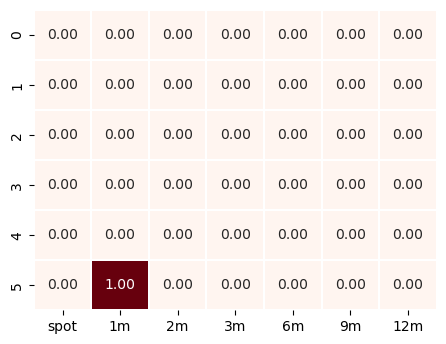

In [8]:
# convolution for carry signal
conv_carry = np.zeros(shape=(lookback, n_tenors), dtype=float)
conv_carry[-1, 1] = 1

fig = plot_convolution_filter(conv_carry, xticklabels=tenors)
fig.show()

And, not surprizingly, convolving it with the NTSH gives the carry of AUD on 2023-05-01. We use `pytorch.nn.functional.conv2d` for this and have to expand some dimensions along the way.

In [9]:
# get NTSH for AUD on 2023-05-01
one_ntsh = normalize_term_structure(
    tsh.loc[:"2020-12-01", ["aud"]].tail(6)
)

# get that carry! (converting to tensors and expanding dims to conform w/pytorch)
sig_carry = F.conv2d(
    torch.from_numpy(one_ntsh.values)[None, None, ...], 
    torch.from_numpy(conv_carry)[None, None, ...]
).squeeze().numpy()

print("NTSH:")
display(style_time_series(one_ntsh, precision=4))

print("\nthe 1-month carry signal: {:.4f}".format(sig_carry))

NTSH:



the 1-month carry signal: 0.0046


Applying it to the whole cross-section of currencies is simply achieved by setting the stride parameter to the number of tensors.

In [10]:
many_ntsh = normalize_term_structure(
    tsh.loc[:"2020-12-01"].tail(6)
)

print("extracting the 1-month carry signal:")
print(
    F.conv2d(
        torch.from_numpy(many_ntsh.values)[None, None, ...], 
        torch.from_numpy(conv_carry)[None, None, ...],
        stride=(1, n_tenors)
    ).squeeze().numpy().round(4)
)

print("\n")
print("the actual 1-month forward discounts:")
display(style_time_series(many_ntsh.xs("1m", axis=1, level="maturity").tail(1),
                          precision=4))



extracting the 1-month carry signal:
[0.0046 0.0032 0.0165 0.0129 0.0135 0.0073 0.0101 0.0031 0.0011 0.011 ]


the actual 1-month forward discounts:


currency,aud,cad,chf,dkk,eur,gbp,jpy,nok,nzd,sek
date,,,,,,,,,,
2020-12-01,0.0046,0.0032,0.0165,0.0129,0.0135,0.0073,0.0101,0.0031,0.0011,0.0110


These can be used with the softmax activation function to get the weights in a long-short portfolio. I normalize the signals by subtracting the mean and dividing by the standard deviation, and take the modified softmax, forcing the values to be approximately between -1 and 1 and sum to zero.

In [11]:
# calculate signals
signals = F.conv2d(
    torch.from_numpy(many_ntsh.values)[None, None, ...], 
    torch.from_numpy(conv_carry)[None, None, ...],
    stride=(1, n_tenors)
).squeeze()

n_assets = len(signals)

# normalize, take softmax with temperature parameter = 1.5
temp = 1.5
_w = (
    F.softmax((signals - torch.mean(signals)) / torch.std(signals) * temp, dim=0) \
        - 1/n_assets
) * 2
w = pd.DataFrame(_w[None, ...], index=many_ntsh.index[[-1]], 
                 columns=many_ntsh.columns.unique("currency"))

print("long-short portfolio weights:")
style_time_series(w, precision=4)

long-short portfolio weights:


currency,aud,cad,chf,dkk,eur,gbp,jpy,nok,nzd,sek
date,,,,,,,,,,
2020-12-01,-0.1713,-0.1807,0.6734,0.1043,0.1697,-0.1386,-0.0617,-0.1817,-0.1896,-0.0238


These weights are different from the ones frequently used in long-short rank-based strategies, but, hopefully, close enough. The carry trade strategy constructed with such weights is profitable, as shown below:

In [12]:
# normalize and take softmax with a temperature parameter
def normalized_softmax(_x, dim=-1, temp=1.5):
    _res = (
        F.softmax(
            (_x - torch.mean(_x, dim=dim, keepdim=True)) / \
                torch.std(_x, dim=dim, keepdim=True) * \
                temp, 
            dim=dim
        ) - 1/n_assets
    ) * 2
    return _res

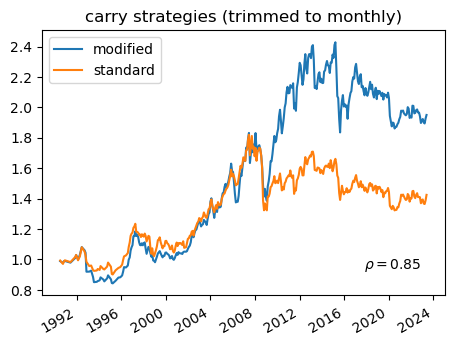

In [13]:
# forward discounts
fd = data["fd_annualized"].xs("1m", axis=1, level="maturity")

# need Tensors to apply `pytorch`.softmax
signals_carry_conv = pd.DataFrame(
    normalized_softmax(torch.from_numpy(fd.values)), 
    index=fd.index, 
    columns=fd.columns
)

signals_carry_standard = get_long_short_legs(fd)

carry_conv_rx = rx.mul(signals_carry_conv).sum(axis=1, min_count=1)
carry_standard_rx = rx.mul(signals_carry_standard).sum(axis=1, min_count=1)

rho = carry_conv_rx.corr(carry_standard_rx)

fig, ax = plt.subplots(figsize=(4*1.3, 3*1.3))
pd.concat((carry_conv_rx, carry_standard_rx), axis=1, 
          keys=["modified", "standard"])\
    .iloc[::22].dropna().add(1).cumprod().plot(ax=ax)
ax.set_title("carry strategies (trimmed to monthly)")
ax.text(0.8, 0.1, r"$\rho = {:.2f}$".format(rho), transform=ax.transAxes)

plt.show()

Can we 'learn' a better filter than the carry from the data? So far, we have seen that a differentiable function &ndash; convolution &ndash; can produce a signal for each currency; another such function &ndash; (modified) softmax &ndash; can map the signals onto portfolio weights. Now, with a differentiable function to map the weights onto a scalar loss at hand, we would have all the ingredients to accomplish the task above. The simplest such function is the one that computes (the negative of) the portfolio return (remember that $rx_t$ is forward-looking):
$$
L(w_t | rx_t) = -dot(w_t, rx_t)
$$

In [14]:
from src.losses import custom_loss_return

In whole, the architecture of a simple learner would look like this:
$$
\underset{[T \times (NM)]}{TSH} \overset{conv}{\longrightarrow} \underset{[1 \times N]}{s} 
    \overset{softmax}{\longrightarrow} \underset{[1 \times N]}{w} 
    \overset{-dot}{\longrightarrow} \underset{[1 \times 1]}{r},
$$
where
the term structure history is mapped onto signals, the signals &ndash; onto portfolio weights, the weights onto the scalar loss that is the negative of the portfolio return. This architecture supports gradient descent learning via back-propagation.


# model

The above architecture can be implemented in `pytorch` as follows:

In [15]:
class ConvNet(nn.Module):
    """Simple 1-layer learner with normal initial weights.

    Parameters
    ----------
    lookback : int
    n_tenors : int
        second (column) dimension of one term structure history
    """
    def __init__(self, lookback, n_tenors):
        super().__init__()

        # conv layer
        self.conv = nn.Conv2d(
            in_channels=1, 
            out_channels=1, 
            kernel_size=(lookback, n_tenors), 
            stride=n_tenors
        )

        # init weights
        with torch.no_grad():
            nn.init.normal_(self.conv.weight, std=0.01)
            nn.init.zeros_(self.conv.bias)

            # the weight of the spot (lower left corner) is zero and not changing
            self.conv.weight[0, 0, -1, 0] = 0.0

        # activation
        self.act = normalized_softmax

    def forward(self, x):
        # forward pass through layers
        x = self.conv(x)

        # channels are irrelevant since `out_channels`=1; final size is (batch, lookback, tenor)
        x = x[:, 0, :, :]

        # activation
        x = self.act(x)

        return x

Let's initialize a model instance and see what the convolution filter looks like before we start the training:

/home/ipozdeev/projects/fx-ml-strategies/src/visuals.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels, rotation=0)


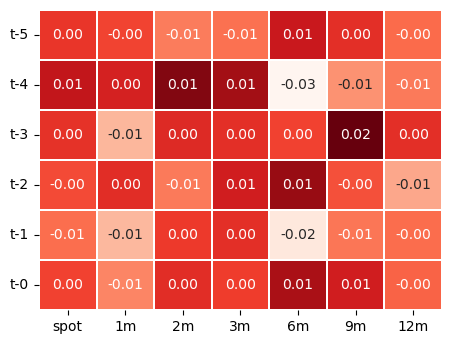

In [16]:
m = ConvNet(lookback=6, n_tenors=n_tenors)
_ = plot_convolution_filter(
    m.conv.weight.detach().numpy()[0, 0, :, :],
    yticklabels=['t-{}'.format(i) for i in list(range(lookback))[::-1]],
    xticklabels=tenors
)

We also implement tailored dataloaders to feed NTSHs into our learner. A more detailed description of dataloaders is provided in a separate notebook; for now, it suffices to know that each works as follows: 
1. sample from the time index in batches, e.g. (2023-01-01, 2005-04-30, ...);
1. for each time stamp, return the NTSH of all currencies as the features...
1. ...and the forward-looking excess returns of the currencies as the labels.

The data used for training is pre-GFC. 

In [17]:
from torch.utils.data import DataLoader
from src.datafeed.dataloader import (
    TermStructureCrossSectionBlockDataset,
    ForwardCrossSectionDataset,
    MultiDataset
)

train_smpl_end = "2015-12-31"
test_smpl_start = "2016-01-01"

# features: NTSH
ds_train_bwd = TermStructureCrossSectionBlockDataset(
    tsh.loc[:train_smpl_end],
    lookback=lookback,
    transform=normalize_term_structure
)

# excess returns for calculation of the sharpe ratio numerator
ds_train_fwd = ForwardCrossSectionDataset(
    rx.loc[:train_smpl_end],
    lookforward=1,
    dropna=True
)

# sample features, labels at once
ds_train = MultiDataset(ds_train_bwd, ds_train_fwd)

# test sample
ds_test = TermStructureCrossSectionBlockDataset(
    tsh.loc[test_smpl_start:],
    lookback=lookback,
    transform=normalize_term_structure
)

# data loaders
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True)
dl_test = DataLoader(ds_test, batch_size=len(ds_test), shuffle=False)

# example
features, labels = next(iter(dl_train))
print("shape of ntsh (batches, lookback, tenors*assets): {}".format(list(features.shape)))
print("shape of rx (batches, 1, assets): {}".format(list(labels.shape)))

shape of ntsh (batches, lookback, tenors*assets): [10, 6, 70]
shape of rx (batches, 1, assets): [10, 1, 10]


Finally, let's implement the training and test loops. For the former, we use the standard back-propagation procedure...

In [18]:
def train_loop(model, loss_func, dataloader, optimizer) -> float:
    """Train model for one epoch.
    
    Assumes `loss_func` returns an average loss across batches.
    """
    # init loss for this epoch
    loss_value = 0.0

    for _batch, (_x, _y) in enumerate(dataloader):
        # _x is (batch, lookback, assets*tenors), but conv2d needs channels
        y_hat = model(_x.unsqueeze(1))

        # y_hat is of dim (batch, 1, assets)
        loss = loss_func(y_hat, _y)

        # back-propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # report
        loss_value -= loss.item()

        if _batch % 40 == 0:
            loss_now, batch_now = loss_value / (_batch + 1) * 1200, _batch * _x.shape[0]
            print(
                "avg rx: {: .2f} | [{:>5d}/{:>5d}]"\
                    .format(loss_now, batch_now, len(dataloader.dataset))
            )
    
    print("epoch done!")

    return loss_value / (_batch + 1) * 1200

...with some optimizer, e.g. `Adam`.

In [19]:
opt = torch.optim.Adam(m.parameters(), lr=5e-03)

For the test loop, we evaluate the model in each period of the test set, which results in a long-short portfolio of currencies to be held for one month, and report the average annualized return of such strategy.

In [20]:
def test_loop(model, x_test_batched, target_rx) -> float:
    """Test the model.
    
    Parameters
    ----------
    model : torch.nn.Module
    x_test_batched : torch.Tensor
        covering the whole test sample, one batch per period (expected to
        have lots of batches)
    target_rx : pandas.DataFrame
        od out-of-sample rx
    """
    with torch.no_grad():
        y_hat = model(x_test_batched.unsqueeze(1))

    y_hat = pd.DataFrame(
        y_hat[:, 0, :].numpy(), 
        index=target_rx.index, 
        columns=target_rx.columns
    )

    y_hat_rx = target_rx.mul(y_hat).sum(axis=1, min_count=1).mean() * 1200

    print("--")
    print("avg rx oos: {: .2f}%".format(y_hat_rx))

    return y_hat_rx


And the test sample, batched:

In [21]:
x_test = next(iter(dl_test))

Let's train the model for 1 epoch.

In [22]:
_ = train_loop(m, custom_loss_return, dl_train, opt)
_ = test_loop(m, x_test_batched=x_test, target_rx=rx.loc[ds_test.index])

avg rx:  8.90 | [    0/ 4546]
avg rx: -1.72 | [  400/ 4546]
avg rx: -2.02 | [  800/ 4546]
avg rx: -1.20 | [ 1200/ 4546]
avg rx: -0.48 | [ 1600/ 4546]
avg rx: -0.23 | [ 2000/ 4546]
avg rx: -0.38 | [ 2400/ 4546]
avg rx:  0.04 | [ 2800/ 4546]
avg rx:  0.09 | [ 3200/ 4546]
avg rx:  0.61 | [ 3600/ 4546]
avg rx:  1.23 | [ 4000/ 4546]
avg rx:  1.42 | [ 4400/ 4546]
epoch done!
--
avg rx oos:  1.51%


We can continue for several, e.g. 50, epochs, recording the values of the in- and out-of-sample return generated by the model.

In [23]:
rx_ins = []
rx_oos = []
epochs = 50

for _e in range(epochs):
    print(f"doing epoch {_e}")
    _rx_i = train_loop(m, custom_loss_return, dl_train, opt)
    _rx_o = test_loop(m, x_test_batched=x_test, target_rx=rx.loc[ds_test.index])
    rx_ins.append(_rx_i)
    rx_oos.append(_rx_o)


doing epoch 0
avg rx:  4.08 | [    0/ 4546]
avg rx:  7.38 | [  400/ 4546]
avg rx:  6.48 | [  800/ 4546]
avg rx:  6.56 | [ 1200/ 4546]
avg rx:  6.06 | [ 1600/ 4546]
avg rx:  6.05 | [ 2000/ 4546]
avg rx:  5.75 | [ 2400/ 4546]
avg rx:  5.66 | [ 2800/ 4546]
avg rx:  5.40 | [ 3200/ 4546]
avg rx:  5.33 | [ 3600/ 4546]
avg rx:  5.21 | [ 4000/ 4546]
avg rx:  5.26 | [ 4400/ 4546]
epoch done!
--
avg rx oos:  1.30%
doing epoch 1
avg rx:  6.81 | [    0/ 4546]
avg rx:  5.68 | [  400/ 4546]
avg rx:  5.14 | [  800/ 4546]
avg rx:  4.08 | [ 1200/ 4546]
avg rx:  4.31 | [ 1600/ 4546]
avg rx:  4.46 | [ 2000/ 4546]
avg rx:  4.42 | [ 2400/ 4546]
avg rx:  4.66 | [ 2800/ 4546]
avg rx:  4.60 | [ 3200/ 4546]
avg rx:  5.02 | [ 3600/ 4546]
avg rx:  5.06 | [ 4000/ 4546]
avg rx:  5.24 | [ 4400/ 4546]
epoch done!
--
avg rx oos:  1.44%
doing epoch 2
avg rx:  3.13 | [    0/ 4546]
avg rx:  4.11 | [  400/ 4546]
avg rx:  5.35 | [  800/ 4546]
avg rx:  5.57 | [ 1200/ 4546]
avg rx:  5.49 | [ 1600/ 4546]
avg rx:  5.11 | [ 20

Let's plot the in- and out-of-sample average per epoch.

/tmp/ipykernel_34273/2099845071.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


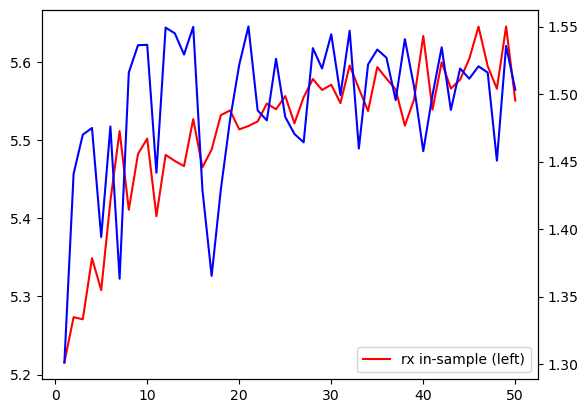

In [28]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(np.arange(len(rx_ins))+1, np.array(rx_ins),
        linestyle="-", color="r", label="rx in-sample (left)")
ax2.plot(np.arange(len(rx_oos))+1, np.array(rx_oos),
         linestyle="-", color="b", label="rx out-of-sample (right)")
ax.legend(loc="lower right")
fig.show()